In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from stacked_mnist import StackedMNISTData, DataMode
from verification_net import VerificationNet
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from auto_encoder import AutoEncoder
from vae import VariationalAutoEncoder
import tensorflow_probability as tfp
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import utils

## Generate datasets

In [3]:
gen = StackedMNISTData(
    mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)

x_train, y_train = gen.get_full_data_set(training=True)
x_test, y_test = gen.get_full_data_set(training=False)

### Validation network
Train the validation network

In [7]:
valid_net = VerificationNet(force_learn=False)
valid_net.train(generator=gen, epochs=100)

img, labels = gen.get_random_batch(training=True,  batch_size=25000)
cov = valid_net.check_class_coverage(data=img, tolerance=.98)
pred, acc = valid_net.check_predictability(data=img, correct_labels=labels)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

Coverage: 100.00%
Predictability: 99.02%
Accuracy: 98.75%


# Auto Encoder

In [5]:
ae = AutoEncoder(force_learn=False, file_name="./models/ae_20_relu")

ae.train(x_train=x_train, x_test=x_test, epochs=25)

Could not read weights for autoencoder from file. Must retrain...
Could not read weights for autoencoder from file. Must retrain...
Epoch 1/25
118/118 [==============================] - 12s 62ms/step - loss: 0.2779 - accuracy: 0.8626 - val_loss: 0.1896 - val_accuracy: 0.8916
Epoch 2/25
118/118 [==============================] - 6s 48ms/step - loss: 0.1411 - accuracy: 0.9336 - val_loss: 0.1028 - val_accuracy: 0.9555
Epoch 3/25
118/118 [==============================] - 4s 35ms/step - loss: 0.1004 - accuracy: 0.9562 - val_loss: 0.0790 - val_accuracy: 0.9666
Epoch 4/25
118/118 [==============================] - 4s 35ms/step - loss: 0.0842 - accuracy: 0.9640 - val_loss: 0.0699 - val_accuracy: 0.9708
Epoch 5/25
118/118 [==============================] - 5s 38ms/step - loss: 0.0767 - accuracy: 0.9675 - val_loss: 0.0647 - val_accuracy: 0.9732
Epoch 6/25
118/118 [==============================] - 4s 35ms/step - loss: 0.0720 - accuracy: 0.9696 - val_loss: 0.0613 - val_accuracy: 0.9748
Epoch 7/2

True

### Reconstruction
Use the verification net to validate the reconstruction ability of the Auto Encoder

#### Mono

In [6]:
img, labels = gen.get_random_batch(training=False,  batch_size=10000)

reconstructed = ae.autoencode(img)

cov = valid_net.check_class_coverage(data=reconstructed, tolerance=.80)
pred, acc = valid_net.check_predictability(data=reconstructed, correct_labels=labels)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

Coverage: 100.00%
Predictability: 97.19%
Accuracy: 95.66%


#### Plots

Plot the original and reconstructed images

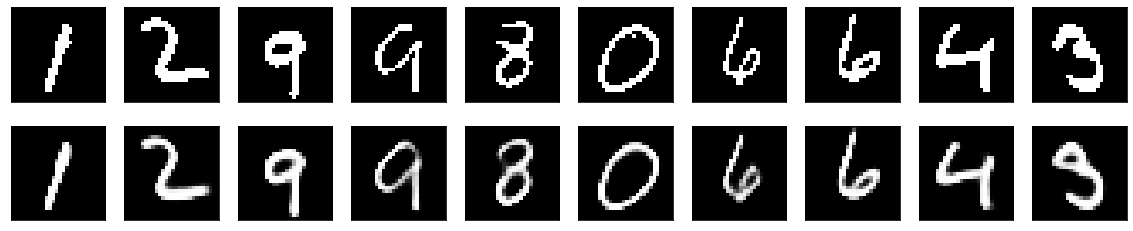

In [12]:
utils.plot_10_images(img, reconstructed,filename='AE_Reconstruct.png', random=True )

#### Color


In [13]:
gen = StackedMNISTData(
    mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=2048)

x_train, y_train = gen.get_full_data_set(training=True)
x_test, y_test = gen.get_full_data_set(training=False)

In [14]:
img, labels = gen.get_random_batch(training=False,  batch_size=10000)

reconstructed = ae.autoencode(img)

cov = valid_net.check_class_coverage(data=reconstructed, tolerance=.50)
pred, acc = valid_net.check_predictability(data=reconstructed, correct_labels=labels)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

Coverage: 99.80%
Predictability: 92.48%
Accuracy: 87.96%


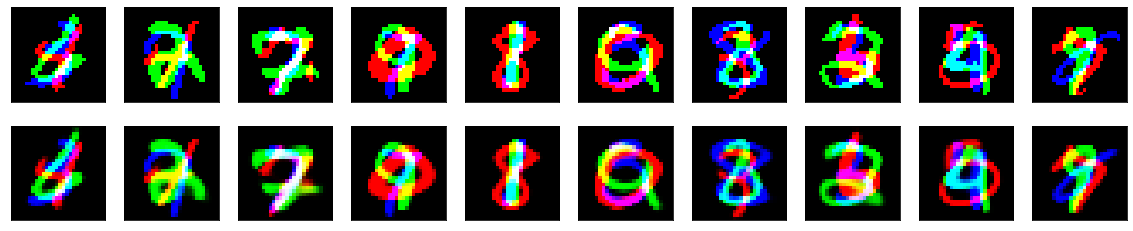

In [15]:
utils.plot_10_images(img.astype(np.float32), reconstructed,filename='AE_Reconstruct_color.png', random=True )

### Generative model

By sending values into the decoder, we can try to generate new images

In [21]:
generated = ae.generate_images(10000, no_channels=1)

Evaluate the images with the verification network

In [22]:
cov = valid_net.check_class_coverage(data=generated, tolerance=.80)
pred, acc = valid_net.check_predictability(data=generated)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

Coverage: 100.00%
Predictability: 53.79%


#### Plots
Plot some of the generated images


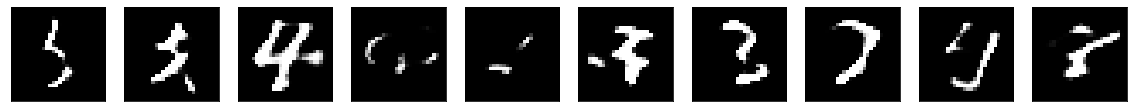

In [23]:
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(generated[i])
plt.savefig('plots/AE_generated_mono')
plt.show()

#### Color

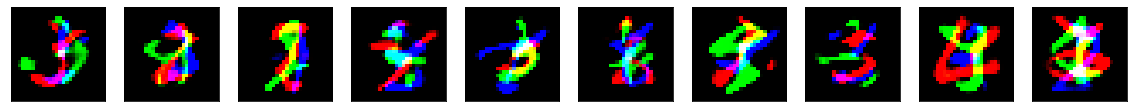

In [24]:
generated = ae.generate_images(10000, no_channels=3)
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(generated[i])
plt.savefig('plots/AE_generated_color')
plt.show()

In [19]:
enc = ae.encode(img)

(Get max z value for use when creating random vectors)

In [20]:
enc.max()

47.00735

### Anomaly detection

First, we train the AE on a dataset with a missing number.

In [25]:
gen = StackedMNISTData(
    mode=DataMode.MONO_BINARY_MISSING, default_batch_size=2048)

x_train, y_train = gen.get_full_data_set(training=True)
x_test, y_test = gen.get_full_data_set(training=False)

In [26]:
ae = AutoEncoder(force_learn=False, file_name="./models/ae_missing_20")

Could not read weights for autoencoder from file. Must retrain...


In [27]:
ae.train(x_train=x_train, x_test=x_test, epochs=25)

Could not read weights for autoencoder from file. Must retrain...
Epoch 1/25
106/106 [==============================] - 7s 41ms/step - loss: 0.3271 - accuracy: 0.8683 - val_loss: 0.1975 - val_accuracy: 0.8993
Epoch 2/25
106/106 [==============================] - 4s 37ms/step - loss: 0.1623 - accuracy: 0.9223 - val_loss: 0.1406 - val_accuracy: 0.9350
Epoch 3/25
106/106 [==============================] - 4s 38ms/step - loss: 0.1335 - accuracy: 0.9393 - val_loss: 0.1233 - val_accuracy: 0.9445
Epoch 4/25
106/106 [==============================] - 4s 37ms/step - loss: 0.1204 - accuracy: 0.9462 - val_loss: 0.1159 - val_accuracy: 0.9481
Epoch 5/25
106/106 [==============================] - 3s 32ms/step - loss: 0.1140 - accuracy: 0.9493 - val_loss: 0.1106 - val_accuracy: 0.9508
Epoch 6/25
106/106 [==============================] - 3s 31ms/step - loss: 0.1098 - accuracy: 0.9514 - val_loss: 0.1086 - val_accuracy: 0.9521
Epoch 7/25
106/106 [==============================] - 3s 29ms/step - loss: 0

True

#### Mono

In [39]:
gen = StackedMNISTData(
    mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)

img, labels = gen.get_random_batch(training=False,  batch_size=2000)

In [29]:
loss = keras.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction="none",
    name="binary_crossentropy",
)

In [40]:
reconstructed = ae.autoencode(img)
losses = loss(img, reconstructed)
losses = np.average(losses, axis=1)
losses = np.average(losses, axis=1)

In [41]:
indices = np.argpartition(losses, -10)[-11:]

In [37]:
losses

array([0.01741679, 0.07748874, 0.17850961, ..., 0.06628643, 0.14497384,
       0.01376311], dtype=float32)

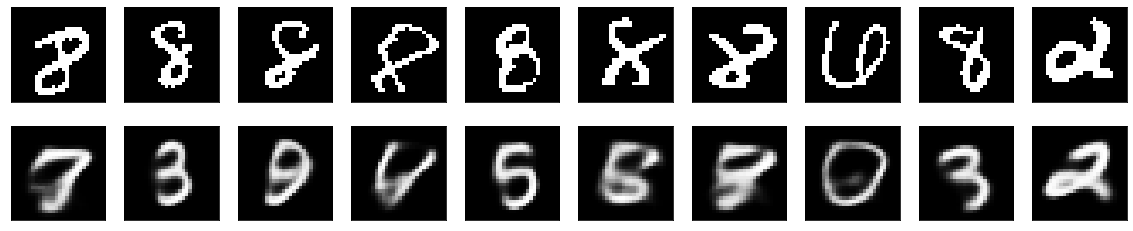

In [42]:
utils.plot_10_images(img[indices].astype(np.float32), reconstructed[indices], filename='AE_anomalies_mono')

#### Color

In [43]:
gen = StackedMNISTData(
    mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=2048)

img, labels = gen.get_random_batch(training=False,  batch_size=2000)

In [44]:
reconstructed = ae.autoencode(img)
losses = loss(img, reconstructed)
losses = np.average(losses, axis=1)
losses = np.average(losses, axis=1)
indices = np.argpartition(losses, -10)[-11:]

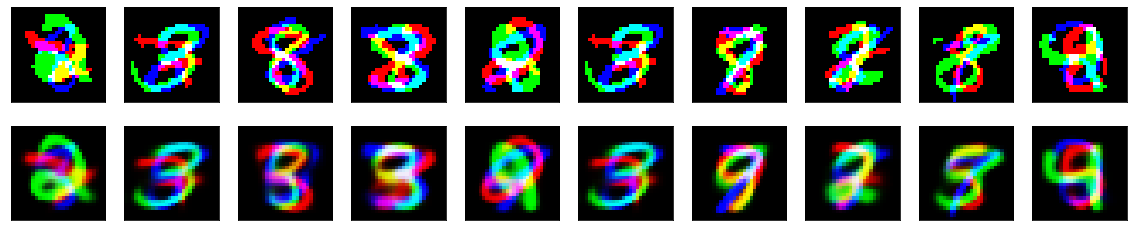

In [45]:
utils.plot_10_images(img[indices].astype(np.float32), reconstructed[indices], filename='AE_anomalies_color')

## Variational Auto Encoder

In [17]:
gen = StackedMNISTData(
    mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)

x_train, y_train = gen.get_full_data_set(training=True)
x_test, y_test = gen.get_full_data_set(training=False)

In [13]:
vae = VariationalAutoEncoder(force_learn=False, file_name="./models/vae_16")

Not trained


In [14]:
vae.train(x_train=x_train, x_test=x_test, epochs=30)

Not trained
Epoch 1/30
118/118 [==============================] - 9s 39ms/step - loss: 252.6366 - accuracy: 0.8677 - val_loss: 197.1124 - val_accuracy: 0.8658
Epoch 2/30
118/118 [==============================] - 4s 35ms/step - loss: 162.7690 - accuracy: 0.9006 - val_loss: 134.0715 - val_accuracy: 0.9358
Epoch 3/30
118/118 [==============================] - 4s 35ms/step - loss: 124.3482 - accuracy: 0.9456 - val_loss: 118.6991 - val_accuracy: 0.9494
Epoch 4/30
118/118 [==============================] - 4s 36ms/step - loss: 115.8324 - accuracy: 0.9536 - val_loss: 113.0152 - val_accuracy: 0.9569
Epoch 5/30
118/118 [==============================] - 4s 35ms/step - loss: 112.3640 - accuracy: 0.9567 - val_loss: 110.4229 - val_accuracy: 0.9573
Epoch 6/30
118/118 [==============================] - 4s 35ms/step - loss: 110.2780 - accuracy: 0.9585 - val_loss: 108.9710 - val_accuracy: 0.9604
Epoch 7/30
118/118 [==============================] - 4s 35ms/step - loss: 108.7074 - accuracy: 0.9598 - v

True

In [18]:
img, labels = gen.get_random_batch(training=False,  batch_size=10000)

reconstructed = vae.autoencode(img)

cov = valid_net.check_class_coverage(data=reconstructed, tolerance=.80)
pred, acc = valid_net.check_predictability(data=reconstructed, correct_labels=labels)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

Coverage: 100.00%
Predictability: 97.30%
Accuracy: 93.42%


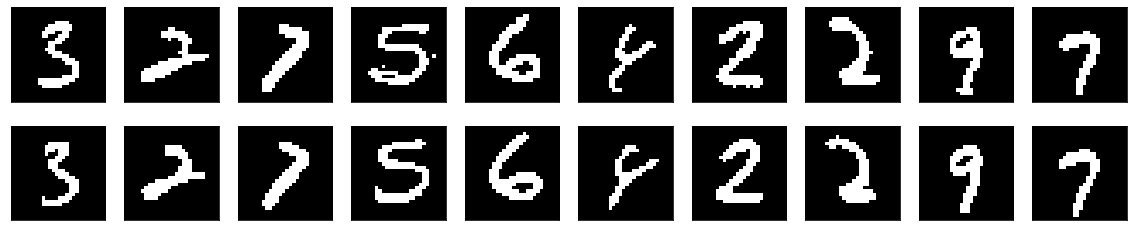

In [21]:
utils.plot_10_images(img, reconstructed, filename='VAE_Reconstruct_mono', random=True)

#### Color

In [25]:
gen = StackedMNISTData(
    mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=2048)

img, labels = gen.get_random_batch(training=False,  batch_size=10000)

reconstructed = vae.autoencode(img)

cov = valid_net.check_class_coverage(data=reconstructed, tolerance=.50)
pred, acc = valid_net.check_predictability(data=reconstructed, correct_labels=labels)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

Coverage: 100.00%
Predictability: 92.60%
Accuracy: 81.91%


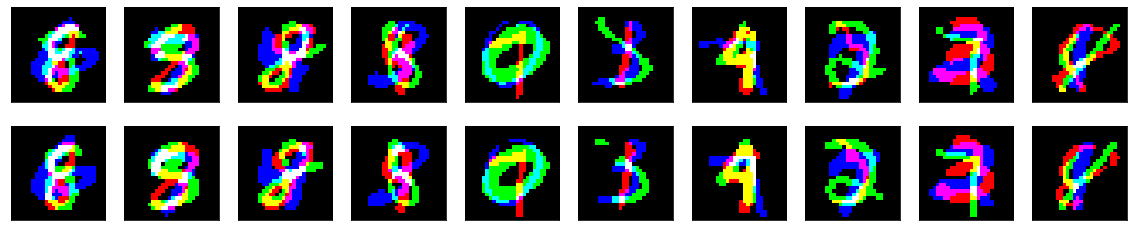

In [23]:
utils.plot_10_images(img.astype(np.float32), reconstructed, filename='VAE_Reconstruct_color', random=True)

### VAE as Generative model

In [56]:
generated = vae.generate_images(10000, no_channels=1)

In [27]:
cov = valid_net.check_class_coverage(data=generated, tolerance=.80)
pred, acc = valid_net.check_predictability(data=generated)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

Coverage: 100.00%
Predictability: 81.21%


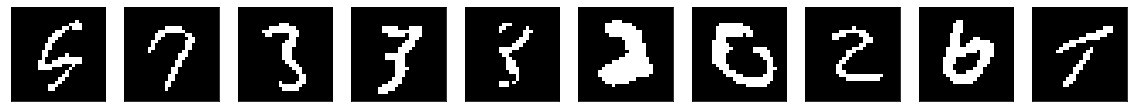

In [57]:
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(generated[i])
plt.savefig('plots/VAE_generated_mono')
plt.show()

#### Color

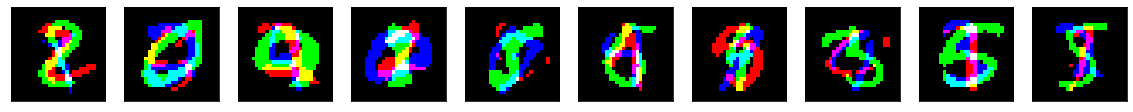

In [58]:
generated = vae.generate_images(10000, no_channels=3)
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(generated[i])
plt.savefig('plots/VAE_generated_color')
plt.show()

### Anomaly detection

In [59]:
loss = keras.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction="none",
    name="binary_crossentropy",
)

In [60]:
gen = StackedMNISTData(
    mode=DataMode.MONO_BINARY_MISSING, default_batch_size=2048)

x_train, y_train = gen.get_full_data_set(training=True)
x_test, y_test = gen.get_full_data_set(training=False)

In [61]:
vae = VariationalAutoEncoder(force_learn=False, file_name="./models/vae_missing_16")

Could not read weights for autoencoder from file. Must retrain...


In [62]:
vae.train(x_train=x_train, x_test=x_test, epochs=35)

Could not read weights for autoencoder from file. Must retrain...
Epoch 1/35
106/106 [==============================] - 8s 43ms/step - loss: 250.4773 - accuracy: 0.8699 - val_loss: 201.4265 - val_accuracy: 0.8658
Epoch 2/35
106/106 [==============================] - 4s 35ms/step - loss: 167.8706 - accuracy: 0.8922 - val_loss: 142.4194 - val_accuracy: 0.9284
Epoch 3/35
106/106 [==============================] - 4s 35ms/step - loss: 126.7250 - accuracy: 0.9433 - val_loss: 122.9713 - val_accuracy: 0.9490
Epoch 4/35
106/106 [==============================] - 4s 35ms/step - loss: 115.7571 - accuracy: 0.9533 - val_loss: 117.5972 - val_accuracy: 0.9520
Epoch 5/35
106/106 [==============================] - 4s 35ms/step - loss: 111.6625 - accuracy: 0.9570 - val_loss: 114.7360 - val_accuracy: 0.9558
Epoch 6/35
106/106 [==============================] - 4s 35ms/step - loss: 109.4022 - accuracy: 0.9589 - val_loss: 112.4032 - val_accuracy: 0.9573
Epoch 7/35
106/106 [==============================] 

True

In [73]:
gen = StackedMNISTData(
    mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)

img, labels = gen.get_random_batch(training=False, batch_size=3000)

In [75]:
ind = vae.get_n_anomalies(100, img)

In [65]:
N = 10000
p_x = np.zeros(len(img))
for i in range(len(img)):

    z = np.random.randn(1, 16)
    dec = vae.decode_channel(z)
    I = img[i:i+1].repeat(N, axis=0)
    p = loss(I,dec)# Shape=(N,28,28)
    p = np.average(p, axis=1) # Shape=(N, 28)
    p = np.average(p, axis=1) # Shape = (N,)

    p = np.exp(-p)
    p = np.average(p)
    p_x[i] = p 

    

    

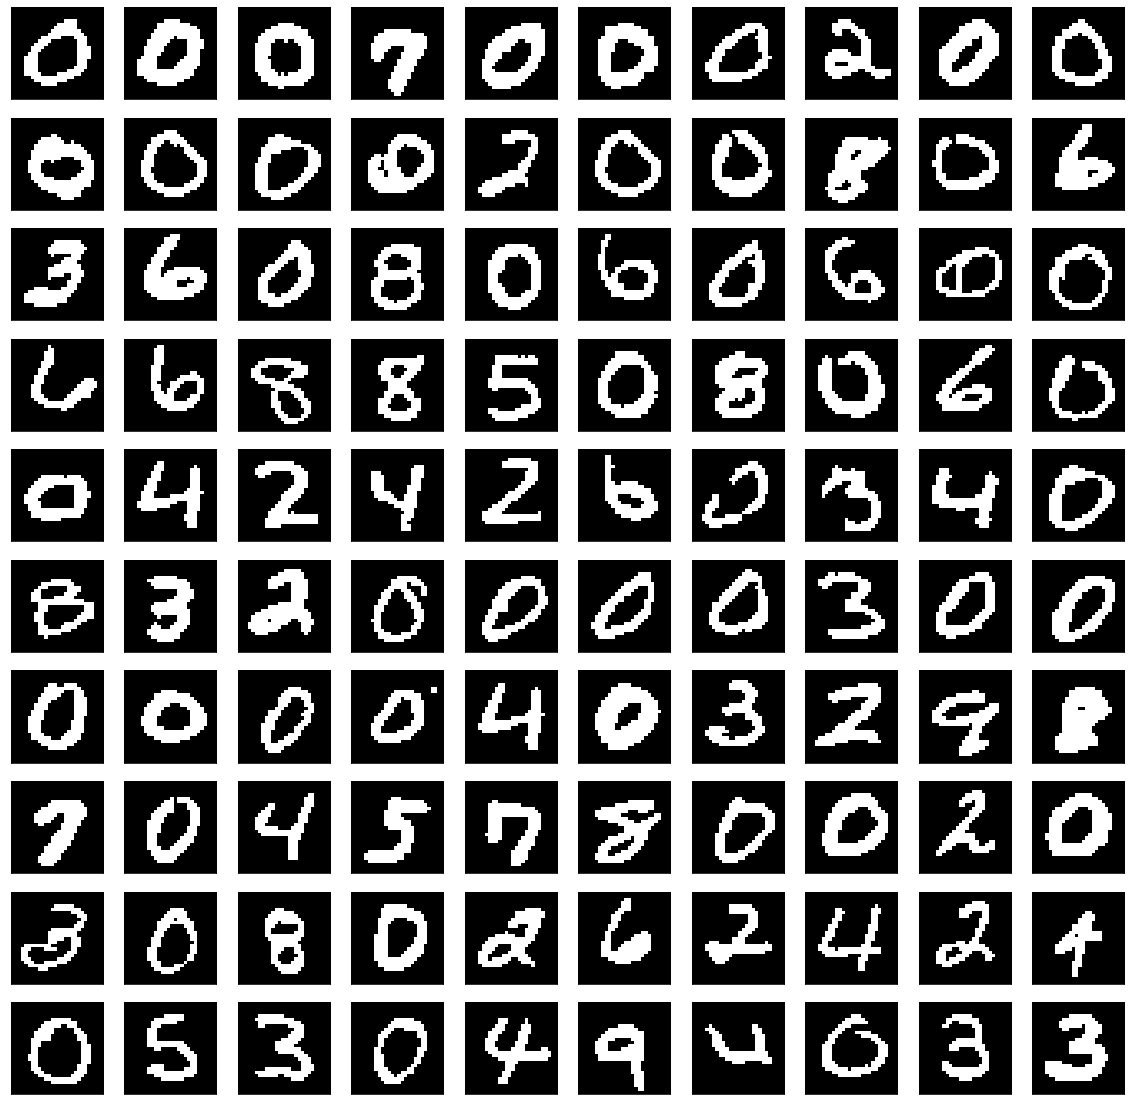

In [76]:
plt.figure(figsize=(20, 20))
for i in range(100):
        ax = plt.subplot(10, 10, i+1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(img[ind[i]])

plt.savefig('plots/VAE_anomalies')
plt.show()

In [68]:
reconstructed = vae.autoencode(img)
losses = loss(img, reconstructed)
losses = np.average(losses, axis=1)
losses = np.average(losses, axis=1)

In [69]:
indices = np.argpartition(losses, -100)[-101:]

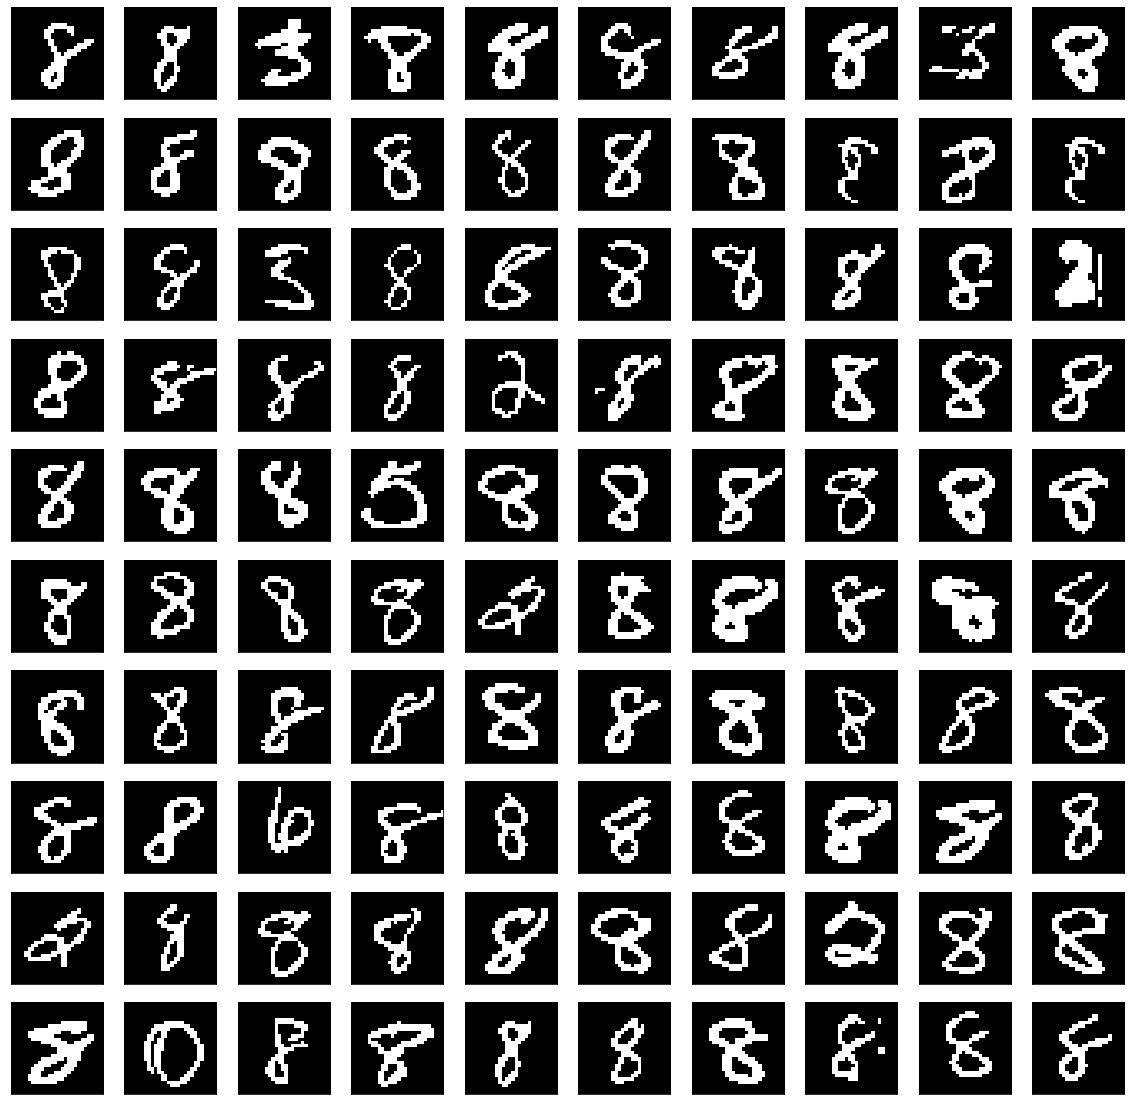

In [70]:
plt.figure(figsize=(20, 20))
for i in range(100):
        ax = plt.subplot(10, 10, i+1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(img[indices[i]])

plt.savefig('plots/VAE_anomalies_')
plt.show()

In [71]:
rec = vae.autoencode(img[indices])

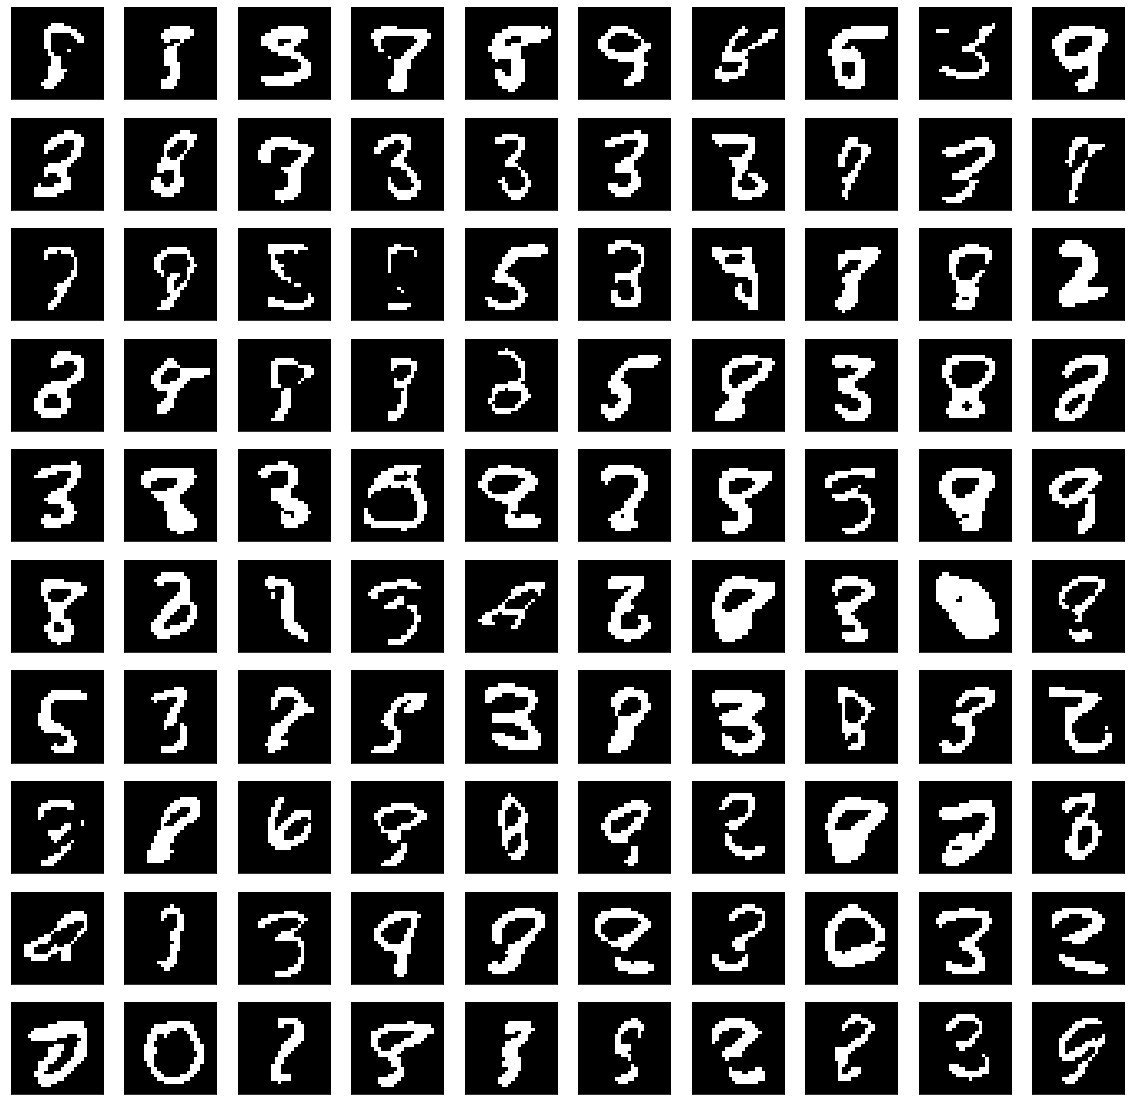

In [72]:
plt.figure(figsize=(20, 20))
for i in range(100):
        ax = plt.subplot(10, 10, i+1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(rec[i])
plt.show()

#### Color

In [77]:
gen = StackedMNISTData(
    mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=2048)

img, labels = gen.get_random_batch(training=False, batch_size=3000)

In [78]:
ind = vae.get_n_anomalies(100, img)

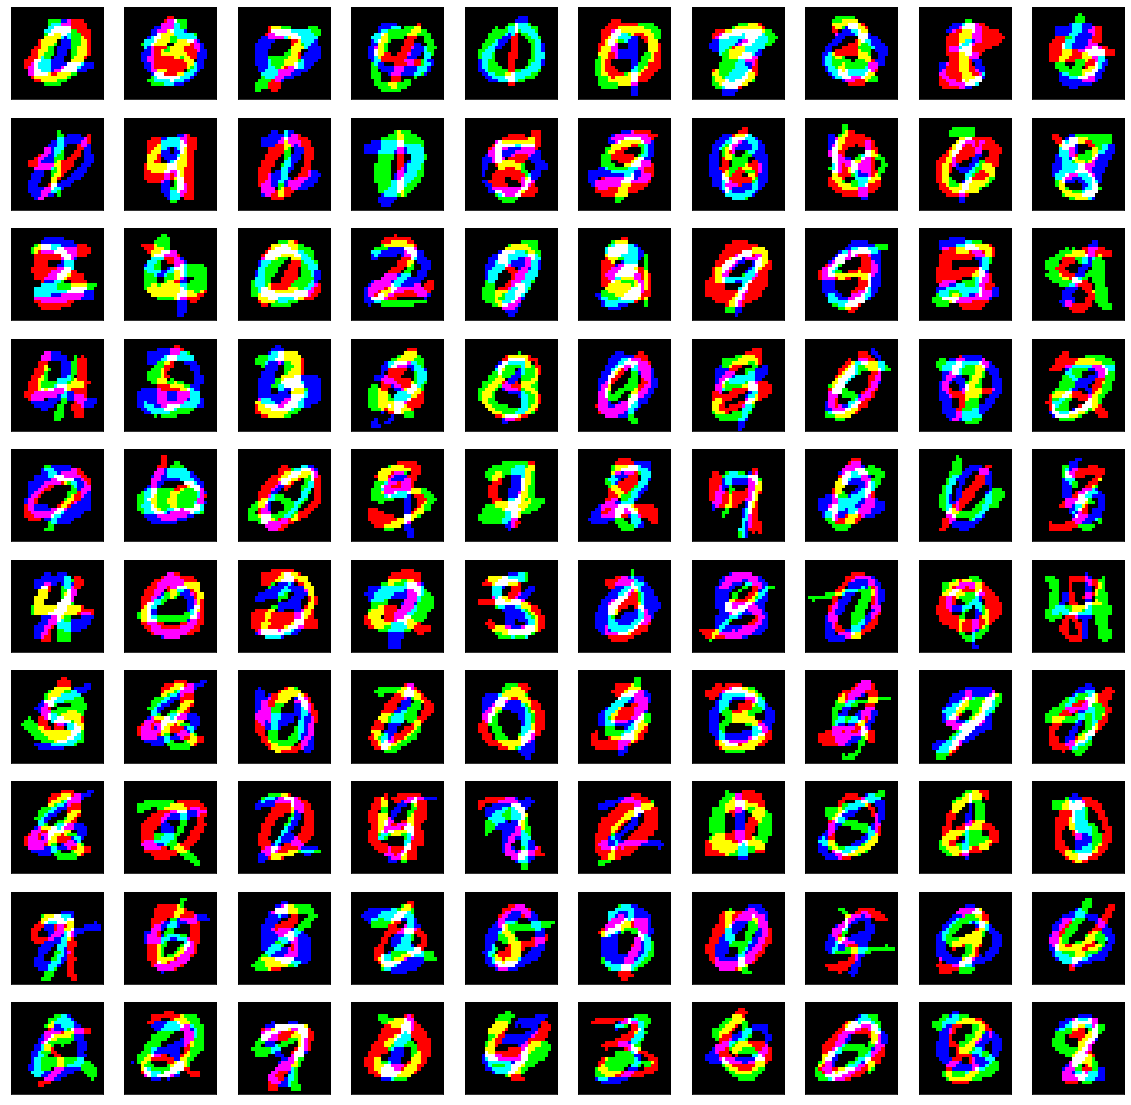

In [80]:
plt.figure(figsize=(20, 20))
for i in range(100):
        ax = plt.subplot(10, 10, i+1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(img.astype(np.float32)[ind[i]])

plt.savefig('plots/VAE_anomalies_color')
plt.show()

In [81]:
reconstructed = vae.autoencode(img)
losses = loss(img, reconstructed)
losses = np.average(losses, axis=1)
losses = np.average(losses, axis=1)
indices = np.argpartition(losses, -100)[-101:]

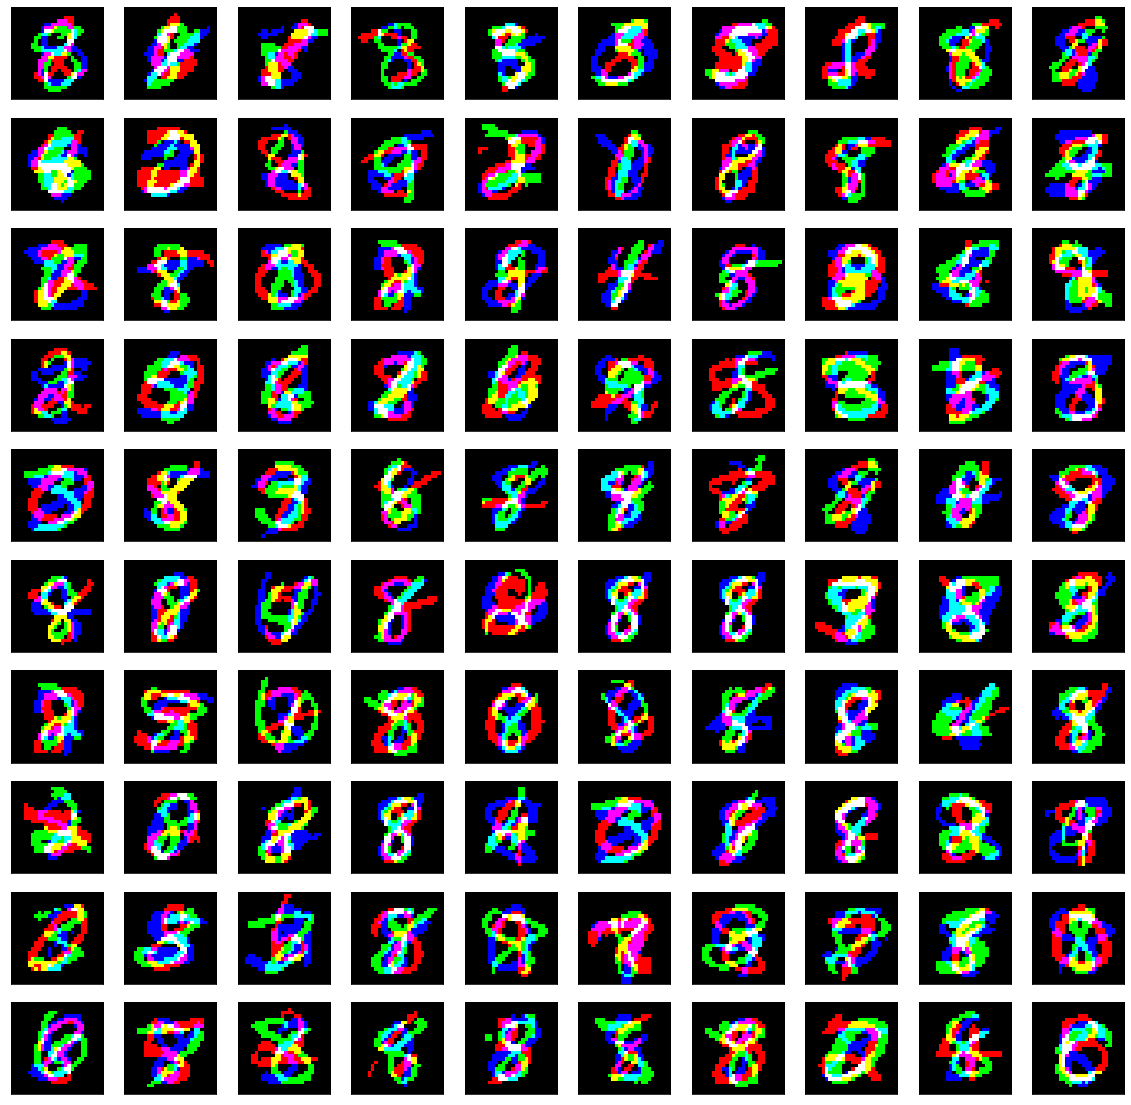

In [83]:
plt.figure(figsize=(20, 20))
for i in range(100):
        ax = plt.subplot(10, 10, i+1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(img.astype(np.float32)[indices[i]])

plt.savefig('plots/VAE_anomalies_color_')
plt.show()